[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JoelCMThan/AI_CV/blob/main/MNIST_in_Keras_COLAB.ipynb)

In [1]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

Updated by: Joel Than for Colab and Visualisation

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [3]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

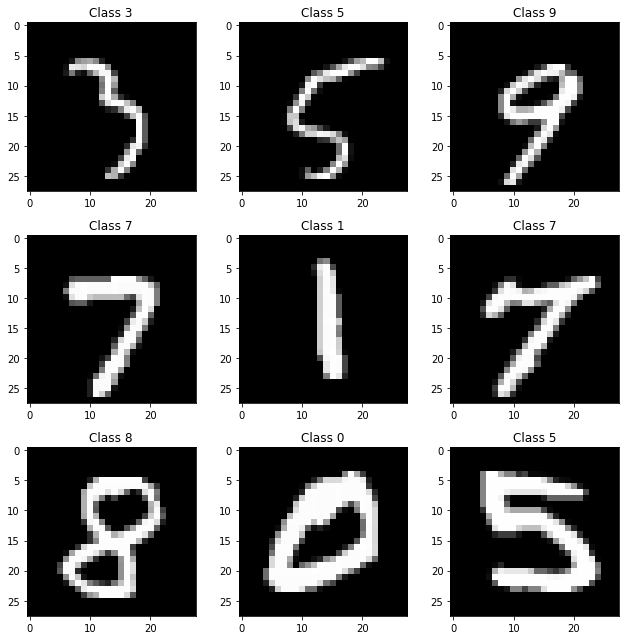

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    
plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [5]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!        
matprint(X_train[num])

0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  
0  0  0  0  0  131  254  254  181  130  130   49   68    7    7    5    0    0    0    0    0    0    0    0    0  0  0  0  
0  0  0  0  0  130  253  253  253  253  253  253  253  253  253  222  136   37   13    8    0    0    0    0    0  0  0  0  
0  0  0  0  0  130  253  253  253  253  253  253  253  253  253  253  253  253  253  213  143   31    2    0    0  0  0  0  
0  0  0  0  0  130  253  253  253  238  228  228  228  228  228  235  253  253  253  253  253  253   79    0    0  0  0  0  


Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [6]:
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [7]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [8]:
# The Sequential model is a linear stack of layers and is very common.

model = Sequential()

## The first hidden layer

In [9]:
# The first hidden layer is a set of 512 nodes (artificial neurons).
# Each node will receive an element from each input vector and apply some weight and bias to it.

model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

In [10]:
# An "activation" is a non-linear function applied to the output of the layer above.
# It checks the new value of the node, and decides whether that artifical neuron has fired.
# The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.
# Those inputs are then not considered to be fired.
# Positive values of a node are unchanged.

model.add(Activation('relu'))

$$f(x) = max (0,x)$$
<img src = 'relu.jpg' >

In [11]:
# Dropout zeroes a selection of random outputs (i.e., disables their activation)
# Dropout helps protect the model from memorizing or "overfitting" the training data.
model.add(Dropout(0.2))

## Adding the second hidden layer

In [12]:
# The second hidden layer appears identical to our first layer.
# However, instead of each of the 512-node receiving 784-inputs from the input image data,
# they receive 512 inputs from the output of the first 512-node layer.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [13]:
# The final layer of 10 neurons in fully-connected to the previous 512-node layer.
# The final layer of a FCN should be equal to the number of desired classes (10 in this case).
model.add(Dense(10))

In [14]:
# The "softmax" activation represents a probability distribution over K different possible outcomes.
# Its values are all non-negative and sum to 1.

model.add(Activation('softmax'))

In [15]:
# Summarize the built model

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

<img src = "gradient_descent.png" >

<img src = "learning_rate.png" >

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

<img src = 'complicated_loss_function.png' >

In [16]:
# Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model!
This is the fun part! 

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

In [17]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1)

Epoch 1/5
469/469 [==============================] - 9s 9ms/step - loss: 0.2541 - accuracy: 0.9235
Epoch 2/5
469/469 [==============================] - 4s 8ms/step - loss: 0.1038 - accuracy: 0.9677
Epoch 3/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0710 - accuracy: 0.9777
Epoch 4/5
469/469 [==============================] - 3s 6ms/step - loss: 0.0589 - accuracy: 0.9812
Epoch 5/5
469/469 [==============================] - 3s 7ms/step - loss: 0.0454 - accuracy: 0.9855


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [18]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.0665 - accuracy: 0.9791
Test score: 0.06653068959712982
Test accuracy: 0.9790999889373779


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [19]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
# predicted_classes = model.predict(X_test)
predict_x=model.predict(X_test) 
predicted_classes=np.argmax(predict_x,axis=1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

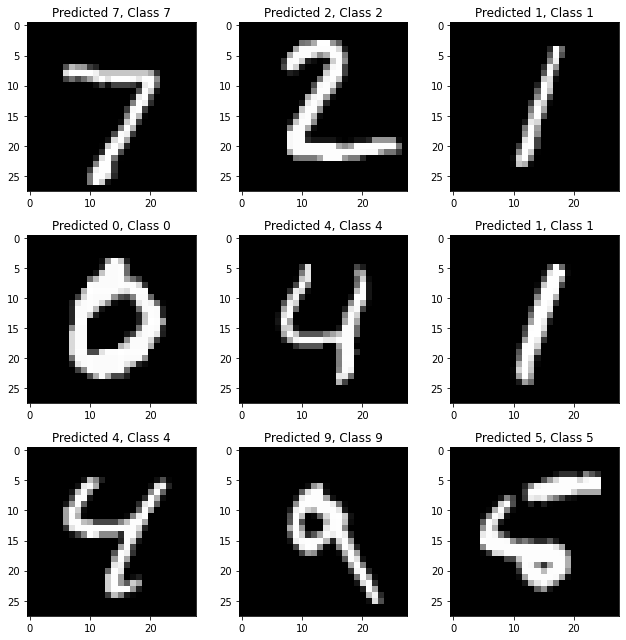

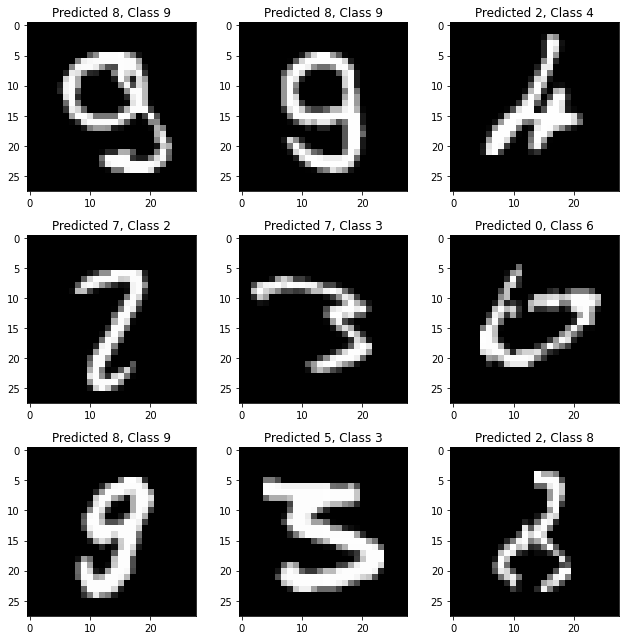

In [20]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))
    
plt.tight_layout()
    
plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))
    
plt.tight_layout()

# Trying experimenting with the batch size!

#### How does increasing the batch size to 10,000 affect the training time and test accuracy?

#### How about a batch size of 32?

# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

<img src = 'convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'max_pooling.png' >

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

<img src = 'go_deeper.jpg' >

## Building a "Deep" Convolutional Neural Network

In [21]:
# import some additional tools
import tensorflow

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization


In [22]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [23]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [24]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [25]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6                       
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 activation_3 (Activation)   (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 24, 24, 32)       

In [27]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [29]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [30]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1, 
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


468/468 [==============================] - 31s 47ms/step - loss: 0.1259 - accuracy: 0.9601 - val_loss: 0.0579 - val_accuracy: 0.9845
Epoch 2/5
468/468 [==============================] - 23s 50ms/step - loss: 0.0502 - accuracy: 0.9846 - val_loss: 0.0411 - val_accuracy: 0.9870
Epoch 3/5
468/468 [==============================] - 22s 46ms/step - loss: 0.0414 - accuracy: 0.9869 - val_loss: 0.0236 - val_accuracy: 0.9909
Epoch 4/5
468/468 [==============================] - 22s 47ms/step - loss: 0.0350 - accuracy: 0.9892 - val_loss: 0.0254 - val_accuracy: 0.9918
Epoch 5/5
468/468 [==============================] - 21s 45ms/step - loss: 0.0305 - accuracy: 0.9902 - val_loss: 0.0175 - val_accuracy: 0.9933


In [31]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 9ms/step - loss: 0.0175 - accuracy: 0.9933
Test score: 0.0175014678388834
Test accuracy: 0.9933000206947327


## Great results! 

But wouldn't it be nice if we could visualize those convolutions so that we can see what the model is seeing?

In [32]:
from keras import backend as K

# choose any image to want by specifying the index
img = X_test[3]
img = np.expand_dims(img, axis=0) # Keras requires the image to be in 4D, so we add an extra dimension to it.

# Not important to understand how this function work -- It just plots a convolution layer

def visualize(layer):
    inputs = [K.learning_phase()] + model.inputs
    
    _convout1_f = K.function(inputs, [layer.output])
    
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    m = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(m)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(15,12))
    for i in range(m):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')


# Visualiser code

In [43]:


import tensorflow.keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
%matplotlib inline

class ModelVisualizationClass(object):
    def __init__(self, model,verbose=True, save_images=False, out_path=os.path.join('.','Activations')):
        self.layer_names = None
        self.activation_model = None
        self.save_images = save_images
        self.out_path = out_path
        self.model = model
        all_layers = model.layers[:]
        self.all_layers = [layer for layer in all_layers if type(layer).__name__.lower().find('input') == -1] # and type(layer).__name__.lower().find('activation') != -1
        if verbose:
            self.print_all_layers()

    def print_all_layers(self):
        for layer in self.all_layers:
            print(layer.name)

    def define_desired_layers(self, desired_layer_names=None):
        all_layers = self.all_layers
        if desired_layer_names:
            all_layers = [layer for layer in all_layers if layer.name in desired_layer_names]
        self.layer_outputs = [layer.output for layer in all_layers]  # We already have the input.
        self.layer_names = [layer.name for layer in all_layers]  #
        self.activation_model = Model(inputs=self.model.input, outputs=self.layer_outputs)

    def predict_on_tensor(self, img_tensor):
        if self.activation_model is None:
            self.define_desired_layers()
        self.activations = self.activation_model.predict(img_tensor)
        if type(self.activations) != list:
            self.activations = [self.activations]

    def define_output(self,out_path):
        self.out_path = out_path
        if not os.path.exists(self.out_path):
            os.makedirs(self.out_path)

    def plot_activations(self, ground_truth=None):
        assert self.activations is not None, 'Need to run predict_on_tensor first!'
        if not self.out_path and self.save_images:
            self.define_output(os.path.join('.','activation_outputs'))
        elif self.save_images:
            self.define_output(self.out_path)
        image_index = 0
        if self.layer_names is None:
            self.define_desired_layers()
        print(self.layer_names)
        if ground_truth is not None:
            ground_truth = np.argmax(np.squeeze(ground_truth),axis=-1)
        for layer_name, layer_activation in zip(self.layer_names, self.activations):
            layer_activation = np.squeeze(layer_activation)
            print(layer_name)
            print(self.layer_names.index(layer_name) / len(self.layer_names) * 100)
            if len(layer_activation.shape) == 4:
                middle_index = layer_activation.shape[0] // 2
                if ground_truth is not None:
                    index = np.where(ground_truth != 0)
                    if index:
                        indexes = np.unique(index[0])
                        middle_index = indexes[len(indexes)//2]
                layer_activation = layer_activation[middle_index,...]
            elif len(layer_activation.shape) == 5:
                layer_activation = layer_activation[0,...,0,:]
            display_grid = make_grid_from_map(layer_activation)
            scale = 0.01
            plt.figure(figsize=(display_grid.shape[1] * scale, scale * display_grid.shape[0]))
            plt.imshow(display_grid, aspect='auto', cmap='gray')
            plt.title(layer_name)
            plt.grid(False)
            if self.save_images:
                plt.savefig(os.path.join(self.out_path, '{}_{}.png'.format(image_index, layer_name.replace("/", '.'))))
                plt.close()
            image_index += 1

    def plot_activation(self, layer_name):
        if not self.out_path and self.save_images:
            self.define_output(os.path.join('.','activation_outputs'))
        elif self.save_images:
            self.define_output(self.out_path)
        image_index = 0
        print(self.layer_names)
        index = self.layer_names.index(layer_name)
        layer_activation = np.squeeze(self.activations[index])
        activation_shape = layer_activation.shape
        print(layer_name)
        if len(activation_shape) == 4:
            layer_activation = layer_activation[activation_shape[0]//2]
        elif len(activation_shape) == 5:
            layer_activation = layer_activation[0,...,0,:]
        display_grid = make_grid_from_map(layer_activation)
        scale = 0.05
        plt.figure(figsize=(display_grid.shape[1] * scale, scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
        if self.save_images:
            plt.savefig(os.path.join(self.out_path, str(image_index) + '_' + layer_name + '.png'))
            plt.close()
        image_index += 1

    def make_grid_from_kernel(self, weights, image_index=0, layer_name=''):
        n_features = weights.shape[-1]
        split = 2
        while n_features / split % 2 == 0 and n_features / split >= split:
            split *= 2
        split /= 2
        images_per_row = int(n_features // split)
        n_cols = n_features // images_per_row
        for i in range(1, n_features + 1):
            plt.subplot(images_per_row, n_cols, i)
            weight = weights[..., i - 1]
            # weight = (weight-np.mean(weight))/np.std(weight)
            plt.imshow(weight, interpolation="nearest", cmap="gray")
        plt.show()
        plt.grid(False)
        if self.save_images:
            plt.savefig(os.path.join(self.out_path, str(image_index) + '_' + layer_name + '.png'))
            plt.close()
        return None

    def plot_kernels(self):
        if not self.out_path and self.save_images:
            self.define_output(os.path.join('.','kernel_outputs'))
        image_index = 0
        for layer_name in self.layer_names:
            print(layer_name)
            layer = [i for i in self.activation_model.layers if i.name == layer_name][0]
            kernels = layer.get_weights()[0]
            if len(kernels.shape) == 4:
                kernels = kernels[...,0,:]
            elif len(kernels.shape) == 5:
                kernels = kernels[0,...,0,:]
            self.make_grid_from_kernel(kernels, image_index=image_index,layer_name=layer_name)
            image_index += 1


def visualize_activations(model, img_tensor, out_path = os.path.join('.','activation_outputs')):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    all_layers = model.layers[1:]
    all_layers = [layer for layer in all_layers if layer.name.find('mask') == -1 and layer.name.lower().find('input') == -1 and layer.name.lower().find('batch_normalization') == -1]
    layer_outputs = [layer.output for layer in all_layers]  # We already have the input.
    layer_names = [layer.name for layer in all_layers]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(img_tensor)
    image_index = 0
    for layer_name, layer_activation in zip(layer_names, activations):
        print(layer_name)
        print(layer_names.index(layer_name)/len(layer_names) * 100)
        layer_activation = np.squeeze(layer_activation)
        display_grid = make_grid_from_map(layer_activation)
        scale = 0.05
        plt.figure(figsize=(display_grid.shape[1] * scale, scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')
        plt.savefig(os.path.join(out_path,str(image_index) + '_' + layer_name + '.png'))
        plt.close()
        image_index += 1


def make_grid_from_map(layer_activation):
    n_features = layer_activation.shape[-1]
    split = 2
    while n_features / split % 2 == 0 and n_features / split >= split:
        split *= 2
    split /= 2
    images_per_row = int(n_features // split)
    if len(layer_activation.shape) == 4:
        rows_size = layer_activation.shape[1]
        cols_size = layer_activation.shape[2]
    else:
        rows_size = layer_activation.shape[0]
        cols_size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((rows_size * images_per_row, n_cols * cols_size))
    for col in range(n_cols):
        for row in range(images_per_row):
            if len(layer_activation.shape) == 4:
                channel_image = layer_activation[layer_activation.shape[0] // 2, :, :, col * images_per_row + row]
            else:
                channel_image = layer_activation[:, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[row * rows_size: (row + 1) * rows_size,
            col * cols_size: (col + 1) * cols_size] = channel_image
    return display_grid


def decay_regularization(img, grads, decay = 0.9):
    return decay * img


def clip_weak_pixel_regularization(img, grads, percentile = 1):
    clipped = img
    threshold = np.percentile(np.abs(img), percentile)
    clipped[np.where(np.abs(img) < threshold)] = 0
    return clipped


def gradient_ascent_iteration(loss_function, img):
    loss_value, grads_value = loss_function([img])
    gradient_ascent_step = img + grads_value * 0.9

    # Convert to row major format for using opencv routines
    grads_row_major = np.transpose(grads_value[0, :], (1, 2, 0))
    img_row_major = np.transpose(gradient_ascent_step[0, :], (1, 2, 0))

    # List of regularization functions to use
    regularizations = [decay_regularization, clip_weak_pixel_regularization]

    # The reguarlization weights
    weights = np.float32([3, 3, 1])
    weights /= np.sum(weights)

    images = [reg_func(img_row_major, grads_row_major) for reg_func in regularizations]
    weighted_images = np.float32([w * image for w, image in zip(weights, images)])
    img = np.sum(weighted_images, axis = 0)

    # Convert image back to 1 x 3 x height x width
    img = np.float32([np.transpose(img, (2, 0, 1))])

    return img


def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def generate_pattern(model, layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[..., filter_index])
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    img = np.random.random((1, size, size, 3)) * 20 + 128.
    for i in range(30):
        img = gradient_ascent_iteration(iterate, img)
    return deprocess_image(img[0])


def visualize_filters(model):
    layer_name = 'block1_conv1'
    size = 64
    margin = 5
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3) ,dtype='uint8')
    for i in range(8):
        print(i)
        for j in range(8):
            filter_img = generate_pattern(model, layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
    plt.figure(figsize=(20, 20))
    plt.imshow(results)


# Sample Visualisation

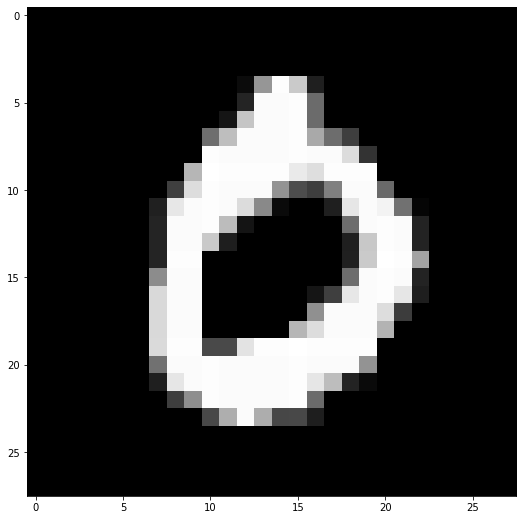

In [33]:
plt.figure()
plt.imshow(X_test[3].reshape(28,28), cmap='gray', interpolation='none')

In [45]:

visualizer = ModelVisualizationClass(model=model, save_images=True,
                                     out_path=r'some_path_to_image_folder')
x = img
visualizer.print_all_layers()  # Prints the names of all your model layers
visualizer.predict_on_tensor(x)  # Predicts on an input image, needed for writing activation images
visualizer.plot_activation('conv2d_1')  # Opens a matplotlib figure and shows activations in grid

conv2d
batch_normalization
activation_3
conv2d_1
batch_normalization_1
activation_4
max_pooling2d
conv2d_2
batch_normalization_2
activation_5
conv2d_3
batch_normalization_3
activation_6
max_pooling2d_1
flatten
dense_3
batch_normalization_4
activation_7
dropout_2
dense_4
activation_8
conv2d
batch_normalization
activation_3
conv2d_1
batch_normalization_1
activation_4
max_pooling2d
conv2d_2
batch_normalization_2
activation_5
conv2d_3
batch_normalization_3
activation_6
max_pooling2d_1
flatten
dense_3
batch_normalization_4
activation_7
dropout_2
dense_4
activation_8
['conv2d', 'batch_normalization', 'activation_3', 'conv2d_1', 'batch_normalization_1', 'activation_4', 'max_pooling2d', 'conv2d_2', 'batch_normalization_2', 'activation_5', 'conv2d_3', 'batch_normalization_3', 'activation_6', 'max_pooling2d_1', 'flatten', 'dense_3', 'batch_normalization_4', 'activation_7', 'dropout_2', 'dense_4', 'activation_8']
conv2d_1


In [46]:

visualizer.plot_activation('conv2d')  # Opens a matplotlib figure and shows activations in grid

['conv2d', 'batch_normalization', 'activation_3', 'conv2d_1', 'batch_normalization_1', 'activation_4', 'max_pooling2d', 'conv2d_2', 'batch_normalization_2', 'activation_5', 'conv2d_3', 'batch_normalization_3', 'activation_6', 'max_pooling2d_1', 'flatten', 'dense_3', 'batch_normalization_4', 'activation_7', 'dropout_2', 'dense_4', 'activation_8']
conv2d
